In [140]:
#Trying to initial the EM algorithm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import seaborn as sns
import pandas as pd
import yfinance as yf
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

In [119]:
#Generate synthetic data

# Parameters for the synthetic data
np.random.seed(0)
mean1 = np.array([2, 2])
cov1 = np.array([[1, 0.5], [0.5, 1]])

mean2 = np.array([4, 4])
cov2 = np.array([[1, -0.5], [-0.5, 1]])

# Generate data
data1 = np.random.multivariate_normal(mean1, cov1, 200)
data2 = np.random.multivariate_normal(mean2, cov2, 200)
data = np.vstack((data1, data2))


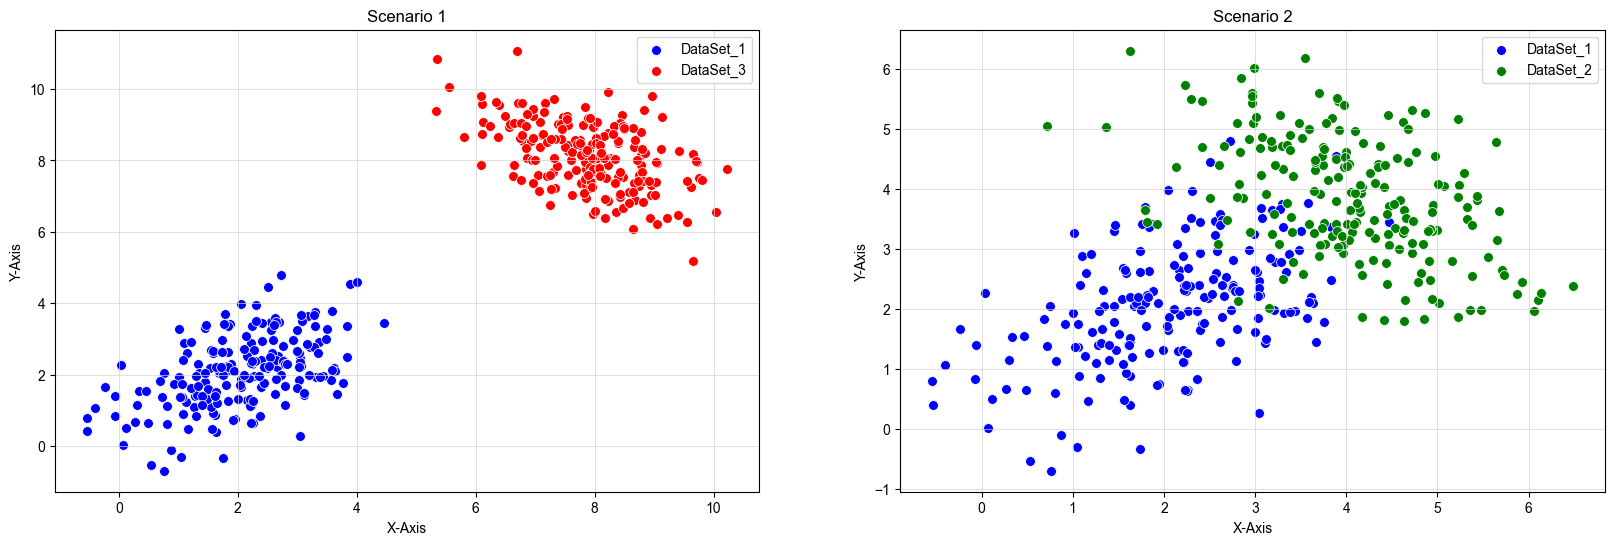

In [129]:
# Parameters for the synthetic data
np.random.seed(0)
mean1 = np.array([2, 2])
cov1 = np.array([[1, 0.5], [0.5, 1]])

mean2 = np.array([4, 4])
cov2 = np.array([[1, -0.5], [-0.5, 1]])


mean3 = np.array([8, 8])
cov3 = np.array([[1, -0.5], [-0.5, 1]])

# Generate data
data1 = np.random.multivariate_normal(mean1, cov1, 200)
data2 = np.random.multivariate_normal(mean2, cov2, 200)
data3 = np.random.multivariate_normal(mean3, cov3, 200)

# Set the font type and size

import matplotlib.pyplot as plt
import seaborn as sns

# Set the font type and size
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = "10"

# Set the figure size
plt.figure(figsize=(20, 6))  # Adjust the figure size to accommodate two plots

# Scatter plot for data1 and data2
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.scatterplot(x=data1[:, 0], y=data1[:, 1], color='blue', label='DataSet_1', s=50)
sns.scatterplot(x=data3[:, 0], y=data3[:, 1], color='red', label='DataSet_3', s=50)
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
plt.title('Scenario 1')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.legend()

# Scatter plot for data1 and data3
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.scatterplot(x=data1[:, 0], y=data1[:, 1], color='blue', label='DataSet_1', s=50)
sns.scatterplot(x=data2[:, 0], y=data2[:, 1], color='green', label='DataSet_2', s=50)
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
plt.title('Scenario 2')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.legend()

plt.show()

In [121]:
#We'll initialize the means, covariances, and mixing coefficients randomly.

def initialize_parameters(data, k):
    n, d = data.shape
    means = data[np.random.choice(n, k, False)]
    covariances = np.array([np.cov(data, rowvar=False)] * k)
    mixing_coefficients = np.ones(k) / k
    return means, covariances, mixing_coefficients

# Number of components (regimes)
k = 2

# Initialize parameters
means, covariances, mixing_coefficients = initialize_parameters(data, k)


In [122]:
#E-Step: Expectation Step
def e_step(data, means, covariances, mixing_coefficients):
    n, d = data.shape
    k = means.shape[0]
    
    responsibilities = np.zeros((n, k))
    
    for i in range(k):
        responsibilities[:, i] = mixing_coefficients[i] * multivariate_normal.pdf(data, mean=means[i], cov=covariances[i])
    
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
    
    return responsibilities


In [123]:
#M-Step: Maximization Step
def m_step(data, responsibilities):
    n, d = data.shape
    k = responsibilities.shape[1]
    
    nk = responsibilities.sum(axis=0)
    means = np.dot(responsibilities.T, data) / nk[:, np.newaxis]
    covariances = np.zeros((k, d, d))
    
    for i in range(k):
        diff = data - means[i]
        covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / nk[i]
    
    mixing_coefficients = nk / n
    
    return means, covariances, mixing_coefficients


In [124]:
#Calculate the log-likelihood of the data given the current parameters.
def log_likelihood(data, means, covariances, mixing_coefficients):
    n, d = data.shape
    k = means.shape[0]
    
    log_likelihood = 0
    for i in range(k):
        log_likelihood += mixing_coefficients[i] * multivariate_normal.pdf(data, mean=means[i], cov=covariances[i])
    
    return np.log(log_likelihood).sum()

In [125]:
#Combine the E-step and M-step to iteratively update the parameters until convergence.
def gmm_em(data, k, tol=1e-4, max_iter=100):
    means, covariances, mixing_coefficients = initialize_parameters(data, k)
    log_likelihoods = []
    
    for _ in range(max_iter):
        responsibilities = e_step(data, means, covariances, mixing_coefficients)
        means, covariances, mixing_coefficients = m_step(data, responsibilities)
        log_likelihoods.append(log_likelihood(data, means, covariances, mixing_coefficients))
        
        if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    
    return means, covariances, mixing_coefficients, log_likelihoods

# Run the EM algorithm
means, covariances, mixing_coefficients, log_likelihoods = gmm_em(data, k)


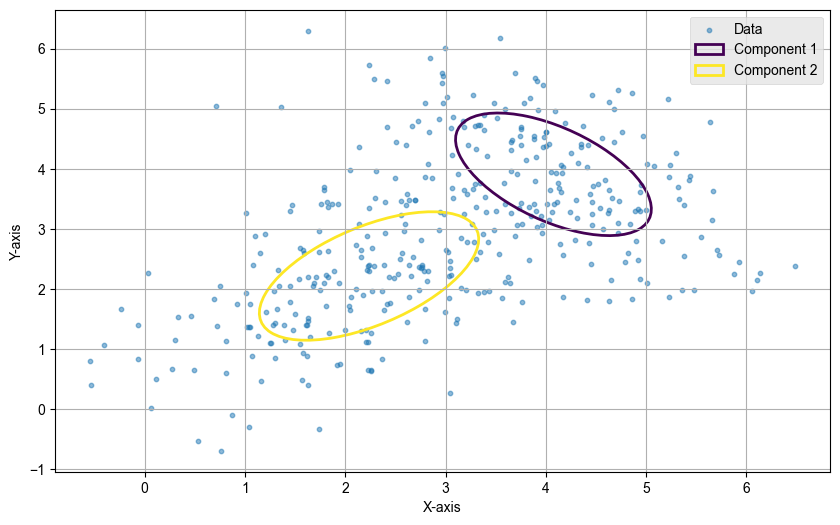

In [132]:
# Set the font type and size
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = "10"

# Set the figure size
plt.figure(figsize=(10, 6))

# Scatter plot with transparency
plt.scatter(data[:, 0], data[:, 1], s=10, label='Data', alpha=0.5)

# Define a color palette for the components
colors = plt.cm.viridis(np.linspace(0, 1, k))

for i in range(k):
    mean = means[i]
    cov = covariances[i]
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)
    ellip = Ellipse(mean, width=width, height=height, angle=angle, edgecolor=colors[i], facecolor='none', linewidth=2, label=f'Component {i+1}')
    plt.gca().add_patch(ellip)

# Use a style context to make the grid less prominent
with plt.style.context('ggplot'):
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed


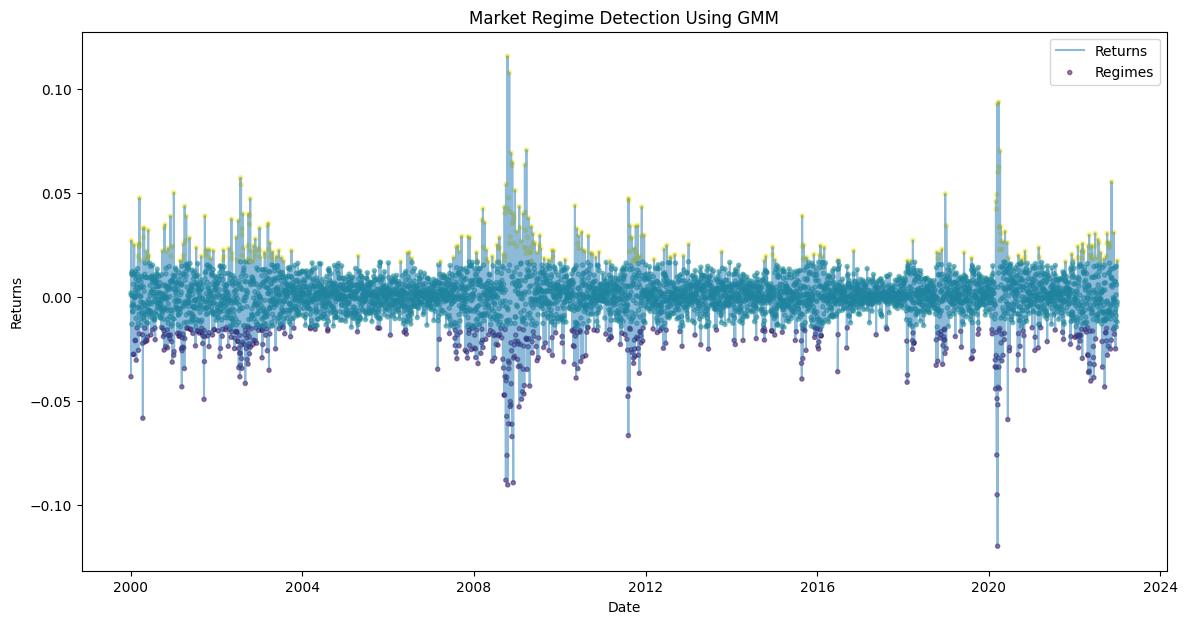

In [1]:
# Download historical stock prices (e.g., S&P 500)
data = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')
returns = data['Adj Close'].pct_change().dropna()

# Fit a GMM to the returns
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(returns.values.reshape(-1, 1))

# Predict the regime for each return
regimes = gmm.predict(returns.values.reshape(-1, 1))

# Plot the regimes
plt.figure(figsize=(14, 7))
plt.plot(returns.index, returns, label='Returns', alpha=0.5)
plt.scatter(returns.index, returns, c=regimes, cmap='viridis', marker='.', alpha=0.5, label='Regimes')
plt.title('Market Regime Detection Using GMM')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


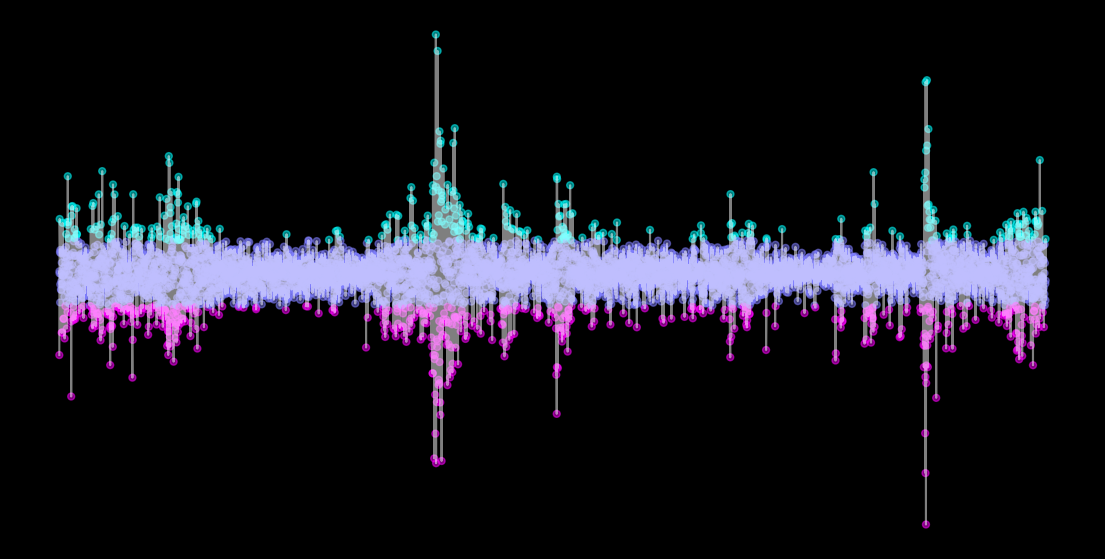

In [139]:
# Set the font type
plt.rcParams["font.family"] = "Arial"

# Download historical stock prices (e.g., S&P 500)
data = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')
returns = data['Adj Close'].pct_change().dropna()

# Fit a GMM to the returns
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(returns.values.reshape(-1, 1))

# Predict the regime for each return
regimes = gmm.predict(returns.values.reshape(-1, 1))

# Plot the regimes
fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor('black')  # Set the figure background to black
ax.set_facecolor('black')  # Set the axes background to black
plt.plot(returns.index, returns, alpha=0.5, color='white')  # Make the line white to stand out against the dark background
ax.axis("off")
plt.scatter(returns.index, returns, c=regimes, cmap='cool', marker='.', alpha=0.5, s=100)  # Use a color map that stands out, and increase the size of the points
plt.box(False)  # Remove the box around the plot
plt.show()

[*********************100%%**********************]  1 of 1 completed


No negative variances.


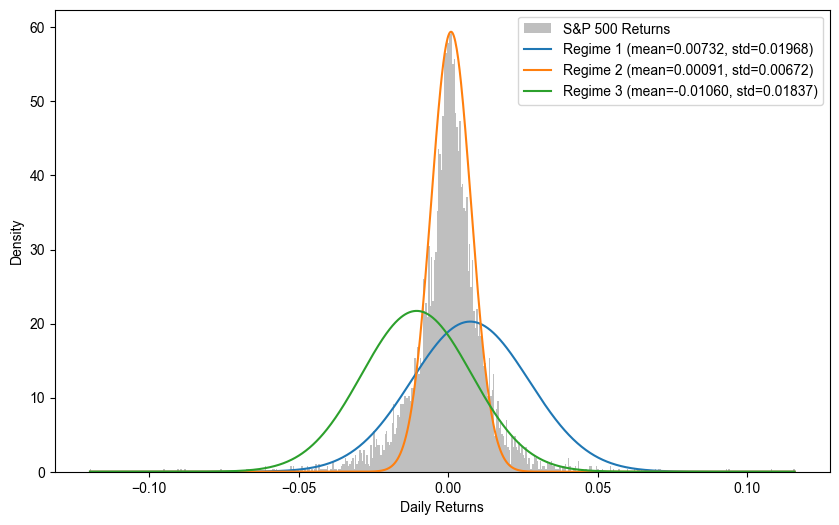

In [135]:
# Download historical stock prices (e.g., S&P 500)
data = yf.download('^GSPC', start='2000-01-01', end='2023-01-01')
returns = data['Adj Close'].pct_change().dropna()

# Fit a GMM to the returns
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(returns.values.reshape(-1, 1))

# Predict the regime for each return
regimes = gmm.predict(returns.values.reshape(-1, 1))

# Extract the means and covariances (variances) of the regimes
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
variances = covariances  # For univariate data, covariances are the variances
std_devs = np.sqrt(variances)  # Calculate standard deviations

# Check for any negative variances (should not happen with correct fitting)
if any(variances < 0):
    print("Warning: Negative variances found.")
else:
    print("No negative variances.")

# Plotting the PDFs of the three regimes
x = np.linspace(returns.min(), returns.max(), 1000)

pdfs = [norm.pdf(x, means[i], std_devs[i]) for i in range(3)]

# Set the font type and size
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = "10"

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=500, density=True, alpha=0.5, color='gray', label='S&P 500 Returns')
for i, pdf in enumerate(pdfs):
    plt.plot(x, pdf, label=f'Regime {i+1} (mean={means[i]:.5f}, std={std_devs[i]:.5f})')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.legend()
plt.show()